In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

In [3]:
#open and combine all data
base_key = 'BTCUSD'
other_keys =('ETHUSD', 'SOLUSD', 'DOTUSD', 'ADAUSD', 'ALGOUSD')
full_df = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', base_key+'.csv'))
full_df['dtime'] = pd.to_datetime(full_df['dtime'], format='%Y-%m-%d %H:%M:%S')
full_df.set_index('dtime', inplace = True)
full_df.drop(columns=['time'], inplace=True)
full_df = full_df.add_prefix(base_key+'_')

for key in other_keys:
    price_data = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', key+'.csv'))
    price_data['dtime'] = pd.to_datetime(price_data['dtime'], format='%Y-%m-%d %H:%M:%S')
    price_data.set_index('dtime', inplace = True)
    price_data.drop(columns=['time'], inplace=True)
    price_data = price_data.add_prefix(key+'_')
    full_df = pd.merge_asof(full_df, price_data, left_index=True, right_index=True, direction='nearest')

full_df.dropna(inplace=True, axis=0, how='all')

#normalize data
norm_df = full_df.copy()
for key in full_df.keys():
    norm_df[key] = (full_df[key] - full_df[key].mean()) / full_df[key].std()

In [7]:
norm_df.values.shape    

(630528, 42)

In [8]:
norm_df

,BTCUSD_open,BTCUSD_high,BTCUSD_low,BTCUSD_close,BTCUSD_vwap,BTCUSD_volume,BTCUSD_count,ETHUSD_open,ETHUSD_high,ETHUSD_low,...,ADAUSD_vwap,ADAUSD_volume,ADAUSD_count,ALGOUSD_open,ALGOUSD_high,ALGOUSD_low,ALGOUSD_close,ALGOUSD_vwap,ALGOUSD_volume,ALGOUSD_count
dtime,,,,,,,,,,,,,,,,,,,,,
2022-04-13 17:33:00,2.927540,2.925667,2.929459,2.927579,2.777088,-0.199009,-0.329345,3.481796,3.480127,3.483342,...,3.003636,0.136680,0.043855,3.437836,3.436545,3.438885,3.437627,-0.608540,-0.089799,-0.290110
2022-04-13 17:34:00,2.927540,2.925667,2.919971,2.918094,2.773286,-0.182037,0.240725,3.481796,3.480151,3.478794,...,3.002958,-0.143306,-0.226992,3.420963,3.419676,3.422008,3.420755,3.950679,-0.089220,-0.052402
2022-04-13 17:35:00,2.918054,2.916462,2.918544,2.918355,2.767672,-0.190197,-0.129820,3.475357,3.473763,3.476902,...,-1.000672,-0.143450,-0.317274,3.420963,3.419676,3.422008,3.420755,-0.608540,-0.089799,-0.290110
2022-04-13 17:36:00,2.918333,2.916462,2.911301,2.909426,2.763706,-0.098493,-0.101317,3.475406,3.473738,3.472035,...,3.005654,-0.143347,-0.226992,3.420963,3.419676,3.422008,3.420755,-0.608540,-0.089799,-0.290110
2022-04-13 17:37:00,2.909369,2.907519,2.908342,2.906468,2.757848,-0.256153,-0.329345,3.464495,3.462828,3.463556,...,3.000183,-0.018628,0.224419,3.410718,3.409435,3.411761,3.410511,3.942293,-0.089219,-0.052402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13 16:29:00,1.164454,1.163038,1.161631,1.160214,1.121427,1.806502,1.893929,0.732881,0.731646,0.723813,...,0.318652,1.212515,1.849497,-1.301342,-1.300517,-1.302239,-1.302171,0.084725,-0.012944,0.660723
2023-07-13 16:30:00,1.160189,1.161368,1.161631,1.162755,1.120464,-0.171135,0.155215,0.728384,0.728132,0.728434,...,0.318980,0.212512,0.946676,-1.302396,-1.298634,-1.303670,-1.298706,0.085465,5.402125,5.890303
2023-07-13 16:31:00,1.162730,1.161316,1.159977,1.158561,1.119240,0.035841,1.295355,0.729367,0.728132,0.725288,...,0.316934,-0.075247,0.314701,-1.301342,-1.299764,-1.303294,-1.303225,0.085773,2.481050,2.800096


In [9]:
#print max and min of each column
for key in norm_df.keys():
    print(key, norm_df[key].max(), norm_df[key].min())  

BTCUSD_open 3.2572003987721883 -1.5188315597299806
BTCUSD_high 3.255485509935752 -1.5158438196378656
BTCUSD_low 3.2548218324594846 -1.524537701301007
BTCUSD_close 3.2569295074139086 -1.518846177327659
BTCUSD_vwap 3.0861241280177927 -3.9226635457463743
BTCUSD_volume 85.00684033548805 -0.2605247967062368
BTCUSD_count 71.6705364435118 -0.5858767058229754
ETHUSD_open 3.7266169056387177 -4.082511439531455
ETHUSD_high 3.7300690008430917 -4.082986479247075
ETHUSD_low 3.7221239549447915 -4.081968410245761
ETHUSD_close 3.72789017936428 -4.082410236516788
ETHUSD_vwap 2.5442219603729783 -2.135144365761863
ETHUSD_volume 92.08634847295869 -0.2045207842156378
ETHUSD_count 84.42753432125959 -0.32592586141135654
SOLUSD_open 4.246996428581309 -1.5924895407606658
SOLUSD_high 4.245770511158386 -1.5924283334660247
SOLUSD_low 4.23877189875239 -1.5925542203160297
SOLUSD_close 4.247030056818325 -1.5924886178104118
SOLUSD_vwap 3.966563451359289 -0.9682681928595922
SOLUSD_volume 129.06522780228366 -0.194368109

In [79]:
class price_dataset(Dataset):
    def __init__(self, df, window_size, target_keys):
        self.df = df
        self.window_size = window_size
        self.target_keys = target_keys
        self.stacked_data = []
        for key in target_keys:
            self.stacked_data.extend(self.df[key].values)
        self.stacked_data = np.array(self.stacked_data)

    def __len__(self):
        return len(self.stacked_data) - self.window_size

    def __getitem__(self, idx):
        chunk = self.stacked_data[idx:idx+self.window_size]
        #divide by first value to normalize
        # chunk = chunk / chunk[0]
        # standardize chunk
        chunk = (chunk - chunk.mean()) / chunk.std()
        return torch.tensor(chunk).type(torch.float32).unsqueeze(0)

window_size = 512
batch_size = 64
train_test_split = 0.8
keys = ['BTCUSD_close', 'ETHUSD_close'] #, 'SOLUSD_close', 'DOTUSD_close', 'ADAUSD_close', 'ALGOUSD_close']
train_dl = DataLoader(price_dataset(full_df[0:int(.8*len(full_df))], window_size, keys), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(price_dataset(full_df[int(.8*len(full_df)):], window_size, keys), batch_size=batch_size, shuffle=True)

In [80]:
itrtr = iter(train_dl)
x = next(itrtr)
x.shape

torch.Size([64, 1, 512])

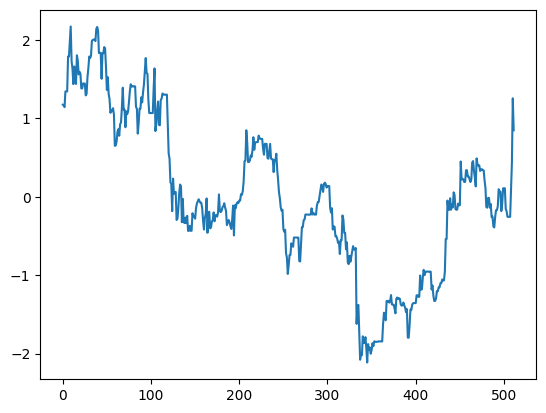

In [81]:
#plot random sample
rand_idx = np.random.randint(0, len(x))
plt.plot(x[rand_idx][0].numpy())

In [104]:
#CNN Autoencoder

# class Autoencoder(nn.Module):
#     def __init__(self, latent_dim, out_dim):
#         super(Autoencoder, self).__init__()
#         self.latent_dim = latent_dim
#         self.out_dim = out_dim
#         # Encoder
#         self.enc1 = nn.Conv1d(1, 64, kernel_size=3, stride=2, padding=1)
#         self.enc2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
#         self.enc3 = nn.Linear(128 * out_dim // 4, latent_dim)  # Assuming the Conv1d layers halve the dimension each
#         # Decoder
#         self.dec1 = nn.Linear(latent_dim, 128 * out_dim // 4)
#         self.dec2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.dec3 = nn.ConvTranspose1d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

#     def forward(self, x):
#         # Encoder
#         x = F.relu(self.enc1(x))
#         x = F.relu(self.enc2(x))
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = F.relu(self.enc3(x))
#         # Decoder
#         x = F.relu(self.dec1(x))
#         x = x.view(x.size(0), 128, self.out_dim // 4)  # Reshape back to [batch_size, channels, length]
#         x = F.relu(self.dec2(x))
#         x = self.dec3(x)
#         return x
        

    
# #test encoder on dataloader
# model = Autoencoder(64, window_size)
# # model = Autoencoder()
# y = model(next(iter(train_dl)))

# # model = Encoder(4)
# # y = model(next(iter(train_dataloader)))
# y.shape

torch.Size([64, 1, 512])

In [162]:
# MLP Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.out_dim = out_dim
        self.l1 = nn.LazyLinear(512)
        self.l2 = nn.LazyLinear(256)
        self.l3 = nn.LazyLinear(128)
        self.l4 = nn.LazyLinear(self.latent_dim)
        self.l5 = nn.LazyLinear(128)
        self.l6 = nn.LazyLinear(256)
        self.l7 = nn.LazyLinear(512)
        self.l8 = nn.LazyLinear(out_dim)


    def forward(self, x):
        # Encoder
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x
        

    
#test encoder on dataloader
model = Autoencoder(64, window_size)
# model = Autoencoder()
y = model(next(iter(train_dl)))

# model = Encoder(4)
# y = model(next(iter(train_dataloader)))
y.shape

c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([64, 1, 512])

In [164]:
def train_loop(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs = data
        inputs = inputs.to(device)  # Move the inputs to the device (GPU or CPU)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, inputs)  # Compute the loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.detach().item()
        print(f"Train epoch: Percent complete: {100 * i / len(dataloader)}", end='\r')
    return running_loss / len(dataloader)

    
def val_loop(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs = data
            inputs = inputs.to(device)  # Move the inputs to the device (GPU or CPU)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, inputs)  # Compute the loss

            running_loss += loss.detach().item()
            print(f"Val epoch: Percent complete: {100 * i / len(dataloader)}", end='\r')

    return running_loss / len(dataloader)


In [249]:
latent_dim = 4
out_dim = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Autoencoder(latent_dim, out_dim).to(device) # GPU
loss_fn = nn.MSELoss()

val_losses = []
train_losses = []



Epoch 1/20, Train Loss: 0.23730092782618945, Val Loss: 0.22152179854685436
Epoch 2/20, Train Loss: 0.21769053988512413, Val Loss: 0.2179430314194541
Epoch 3/20, Train Loss: 0.2178282788679227, Val Loss: 0.21912746583418236
Epoch 4/20, Train Loss: 0.21483411571551442, Val Loss: 0.21705939611071945
Epoch 5/20, Train Loss: 0.21547726119576932, Val Loss: 0.21868406628686418
Epoch 6/20, Train Loss: 0.21444869284215662, Val Loss: 0.2148878787867507
Epoch 7/20, Train Loss: 0.2117920355603201, Val Loss: 0.21693693418903506
Epoch 8/20, Train Loss: 0.21324023758454896, Val Loss: 0.21756342292483635
Epoch 9/20, Train Loss: 0.21465421485610345, Val Loss: 0.22033154236248909
Epoch 10/20, Train Loss: 0.2143470152794528, Val Loss: 0.22193846597930356
Epoch 11/20, Train Loss: 0.21469390768899202, Val Loss: 0.22211359136664713
Epoch 12/20, Train Loss: 0.2132358298757319, Val Loss: 0.22052727685897913
Epoch 13/20, Train Loss: 0.2143946589391814, Val Loss: 0.21854889024964974
Epoch 14/20, Train Loss: 0.2

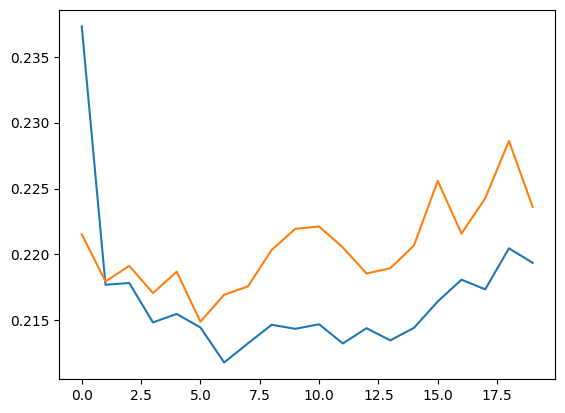

In [250]:
num_epochs = 20
learning_rate = .0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_loss = train_loop(model, train_dl, loss_fn, optimizer, device)
    val_loss = val_loop(model, test_dl, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

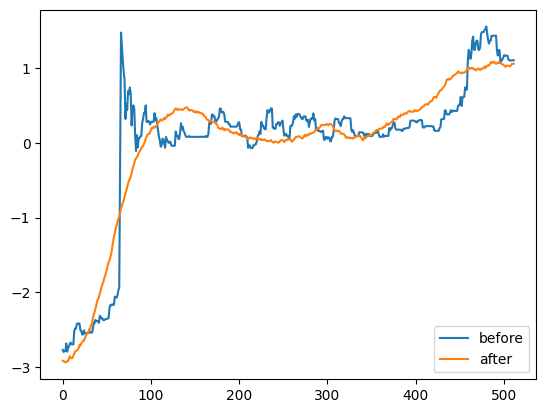

In [255]:
# show example before and after model
model.eval()
with torch.no_grad():
    x = next(iter(train_dl))
    x = x.to(device)
    y = model(x)
    x = x.cpu()
    y = y.cpu()
    rand_idx = np.random.randint(0, len(x))
    plt.plot(x[rand_idx][0].numpy(), label='before')
    plt.plot(y[rand_idx][0].numpy(), label='after')
    plt.legend()
    plt.show()

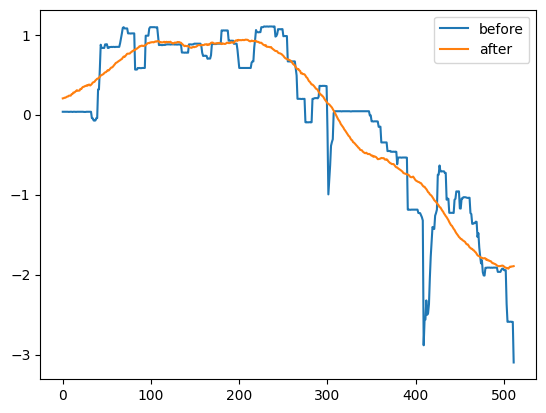

In [257]:
# show val example before and after model
model.eval()
with torch.no_grad():
    x = next(iter(test_dl))
    x = x.to(device)
    y = model(x)
    x = x.cpu()
    y = y.cpu()
    rand_idx = np.random.randint(0, len(x))
    plt.plot(x[rand_idx][0].numpy(), label='before')
    plt.plot(y[rand_idx][0].numpy(), label='after')
    plt.legend()
    plt.show()

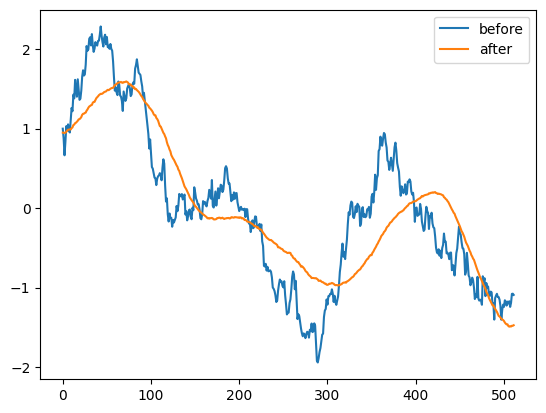

In [265]:
# show random noise example before and after model
model.eval()
with torch.no_grad():
    x = torch.randn(1, 1, window_size)
    x = x.cumsum(dim=2)
    x = (x - x.mean()) / x.std() 
    x = x.to(device)
    y = model(x)
    x = x.cpu()
    y = y.cpu()
    rand_idx = np.random.randint(0, len(x))
    plt.plot(x[rand_idx][0].numpy(), label='before')
    plt.plot(y[rand_idx][0].numpy(), label='after')
    plt.legend()
    plt.show()